<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 4 : Predicting West Nile Virus Infection of Mosquitos in Chicago 
## PART 3/4: Modelling

-----

In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_roc_curve, roc_auc_score, RocCurveDisplay
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support

/Users/kenneththesheep/opt/anaconda3/envs/dsi30/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Import Data

In [3]:
train = pd.read_csv('../Dataset/train_combined_final.csv')
test = pd.read_csv('../Dataset/test_final.csv')

In [4]:
#train.columns

In [5]:
#test.columns

In [6]:
train.drop(labels = ["Unnamed: 0"],axis = 1, inplace=True)
test.drop(labels = ["Unnamed: 0"],axis = 1, inplace=True)

In [7]:
#train.info()

In [8]:
#test.info()

## Feature Selection

In [9]:
final_feat = ['week','distfrom_s1', 'distfrom_s2',  
              'tavg', 'dewpoint', 'preciptotal','humidity', 
              'vcts', 'hz', 'tsra', 'ts', 'fg', 'dz', 'br', 'ra',
       'species_culex pipiens', 'species_culex pipiens/restuans',
       'species_culex restuans', 'trap_group_c2', 'trap_group_c3',
       'trap_group_c4', 'trap_group_c5', 'tavg_lag3_rol3',
       'humidity_lag3_rol3', 'preciptotal_lag3_rol3']

#drop :'wetbulb',tmax','tmin', 'year', 'month','station'
# year and month dropped, we only use week column
# tmax and tmin are highly correlated with tavg so we are not using tmax and tmin because we already use tavg
# we also drop station because we already have distance from station 1 and station 2
# (bigger lag has less relationship to target variable )

## Baseline Model

In [10]:
train['wnvpresent'].value_counts(normalize=True)

0    0.946077
1    0.053923
Name: wnvpresent, dtype: float64

The data is a highly imbalance dataset where there are only 5% of the WNV presence. as such, we need to produce more data and the approach we find produce to find the best model is by using Synthetic Minority Oversampling Technique (SMOTE).

## Data Preparation

### Train/Test Split

In [11]:
X = train[final_feat]
y = train["wnvpresent"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify =y)

### Preprocessing

1. Standard Scaling

In [12]:
ss = StandardScaler()

X_train_sc = ss.fit_transform(X_train)
X_val_sc = ss.transform(X_val)

2. Imbalanced Data Treatment

To handle the imbalanced data, we will need to produce more data by using Synthetic Minority Oversampling Technique (SMOTE).

In [13]:
sm = SMOTE()

X_train_sm, y_train_sm = sm.fit_resample(X_train_sc, y_train)

In [14]:
print(X_train_sm.shape, y_train_sm.shape)

(12828, 25) (12828,)


## Modeling and Hyperparameter Tuning

In order to obtain the various hyperparameters that are optimal for each model, we will fit all the models using GridSearchCV. We will then re-fit the model using these hyperparameters and evaluate the score metrics to determine the best model. Additionally, we wish to interpret the significant features that help the model to predict the results more accurately.

In [15]:
def model_search(model_pipe, params):

  scores = {}

  gs = GridSearchCV(model_pipe, param_grid=params, cv=5, scoring='recall', n_jobs=-1)

  gs.fit(X_train, y_train)

  best_params = gs.best_params_

  best_model = gs.best_estimator_

  best_model.fit(X_train, y_train)

  preds = best_model.predict(X_val)

  #ROC-AUC Score
  roc_auc_train = roc_auc_score(y_train, best_model.predict_proba(X_train)[:,1])
  roc_auc_val = roc_auc_score(y_val, best_model.predict_proba(X_val)[:,1])

  #Confusion matrix
  tn, fp, fn, tp = confusion_matrix(y_val, preds).ravel()
  sensitivity = tp/(tp + fn)
  specificity = tn/(tn + fp)
  accuracy = (tn + tp)/(tn + tp + fn + fp)

  #Append scores
  scores['roc_auc_train'] = roc_auc_train
  scores['roc_auc_val'] = roc_auc_val
  scores['accuracy'] = accuracy
  scores['sensitivity'] = sensitivity
  scores['specificity'] = specificity
  
  return (best_params, best_model, scores)

### Model 1 - Logistic Regression

In [16]:
lr_pipe = Pipeline([
        ('scale', StandardScaler()),
        ('sampling', SMOTE()),
        ('logreg', LogisticRegression(random_state=42))
    ])

lr_params = {
    'sampling__sampling_strategy': [0.8], #[0.55,0.6,0.65]
    'sampling__k_neighbors': [3], #[3,7]
    'logreg__C': [0.45], #[0.5,1.0]
    'logreg__solver': ['liblinear'],
    'logreg__verbose': [1]
}

best_params_lr, best_model_lr, scores_lr = model_search(lr_pipe, lr_params)

print(f"Best params: {best_params_lr}")
print(f"Model Scores: {scores_lr}")

iter  1 act 5.268e+02 pre 4.774e+02 delta 1.117e+00 f 2.881e+03 |g| 1.180e+03 CG   4
iter  1 act 5.987e+02 pre 5.394e+02 delta 1.184e+00 f 2.881e+03 |g| 1.316e+03 CG   4
iter  1 act 5.991e+02 pre 5.377e+02 delta 1.171e+00 f 2.881e+03 |g| 1.291e+03 CG   4
cg reaches trust region boundary
iter  2 act 7.653e+01 pre 6.787e+01 delta 1.364e+00 f 2.282e+03 |g| 2.433e+02 CG   8
cg reaches trust region boundary
cg reaches trust region boundary
iter  2 act 7.859e+01 pre 6.931e+01 delta 1.357e+00 f 2.281e+03 |g| 2.435e+02 CG   8
iter  2 act 6.625e+01 pre 5.945e+01 delta 1.267e+00 f 2.354e+03 |g| 2.113e+02 CG   8
iter  3 act 1.286e+01 pre 1.117e+01 delta 1.267e+00 f 2.287e+03 |g| 4.794e+01 CG  11
iter  3 act 1.247e+01 pre 1.098e+01 delta 1.357e+00 f 2.203e+03 |g| 5.457e+01 CG  12
iter  3 act 1.339e+01 pre 1.176e+01 delta 1.364e+00 f 2.205e+03 |g| 5.303e+01 CG  12
iter  4 act 1.490e+00 pre 1.315e+00 delta 1.364e+00 f 2.192e+03 |g| 7.674e+00 CG  15
iter  4 act 1.374e+00 pre 1.208e+00 delta 1.357e+00

In [17]:
# Logistic regression:
# roc_auc_train = 0.7939454506109416
# roc_auc_val = 0.7959907922501438

### Model 2 - AdaBoost Model

In [18]:
abc_pipe = Pipeline([
        ('scale', StandardScaler()),        
        ('sampling',SMOTE()),
        ('abc', AdaBoostClassifier(random_state=42))
    ])


abc_params = {
    'sampling__sampling_strategy': ['auto'], 
    'sampling__k_neighbors': [2], #[2, 3, 5]
    'abc__learning_rate': [0.1], #[0.1, 0.2, 0.3]
    'abc__n_estimators': [100], #[100, 150, 200]
}

best_params_abc, best_model_abc, scores_abc = model_search(abc_pipe, abc_params)

print(f"Best params: {best_params_abc}")
print(f"Model Scores: {scores_abc}")

Best params: {'abc__learning_rate': 0.1, 'abc__n_estimators': 100, 'sampling__k_neighbors': 2, 'sampling__sampling_strategy': 'auto'}
Model Scores: {'roc_auc_train': 0.8360785661829229, 'roc_auc_val': 0.828002110109342, 'accuracy': 0.6973451327433628, 'sensitivity': 0.8241758241758241, 'specificity': 0.690149625935162}


In [19]:
# AdaBoostClassifier:
# roc_auc_train = 0.8405583925872536
# roc_auc_val = 0.8326402400591927

### Model 3 - GradientBoost Model

In [20]:
gb_pipe = Pipeline([
        ('scale', StandardScaler()),        
        ('sampling',SMOTE()),
        ('gb', GradientBoostingClassifier(random_state=42))
    ])

gb_params = {
    'sampling__sampling_strategy': ['auto'],
    'sampling__k_neighbors': [2], #[2, 3]
    'gb__learning_rate': [0.2], #[0.2, 0.5]
    'gb__max_depth': [3],         #[3, 5]
    'gb__n_estimators': [100], #[100, 200]
}

best_params_gb, best_model_gb, scores_gb = model_search(gb_pipe, gb_params)

print(f"Best params: {best_params_gb}")
print(f"Model Scores: {scores_gb}")

Best params: {'gb__learning_rate': 0.2, 'gb__max_depth': 3, 'gb__n_estimators': 100, 'sampling__k_neighbors': 2, 'sampling__sampling_strategy': 'auto'}
Model Scores: {'roc_auc_train': 0.8991571545168441, 'roc_auc_val': 0.8357471705352005, 'accuracy': 0.8731563421828908, 'sensitivity': 0.5164835164835165, 'specificity': 0.8933915211970075}


In [21]:
# Gradient Boost:
# roc_auc_train = 0.9064001049616532
# roc_auc_val = 0.8399708147214381

### Model 4 - XGBoost Model

In [22]:
xgb_pipe = Pipeline([
        ('scale', StandardScaler()),        
        ('sampling',SMOTE()),
        ('xgb', XGBClassifier(random_state=42, 
                              objective= 'binary:logistic', 
                              verbosity=1, n_jobs=-1))
    ])

xgb_params = { 
    'xgb__learning_rate': [0.1],
    'xgb__max_depth': [40],
    'xgb__min_child_weight': [25],
    'xgb__gamma': [0.85],
    'xgb__subsample': [1],
    'xgb__scale_pos_weight': [63],
    'xgb__n_estimators': [49]
}


best_params_xgb, best_model_xgb, scores_xgb = model_search(xgb_pipe, xgb_params)

print(f"Best params: {best_params_xgb}")
print(f"Model Scores: {scores_xgb}")

/Users/kenneththesheep/opt/anaconda3/envs/dsi30/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:22:13] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/kenneththesheep/opt/anaconda3/envs/dsi30/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:22:16] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best params: {'xgb__gamma': 0.85, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 40, 'xgb__min_child_weight': 25, 'xgb__n_estimators': 49, 'xgb__scale_pos_weight': 63, 'xgb__subsample': 1}
Model Scores: {'roc_auc_train': 0.9475854133972645, 'roc_auc_val': 0.8445918171603957, 'accuracy': 0.6784660766961652, 'sensitivity': 0.8901098901098901, 'specificity': 0.6664588528678305}


In [23]:
# XGBoost:
# roc_auc_train = 0.945882768397682
# roc_auc_val = 0.8482913595133046

### Model 5 - Random Forest

In [24]:
rf_pipe = Pipeline([
        ('scale', StandardScaler()),        
        ('sampling',SMOTE()),
        ('rf', RandomForestClassifier(random_state=42))
    ])

rf_params = { 
    'rf__n_estimators': [100],        #[100, 150, 190]
    'rf__class_weight': ['balanced'],
    'rf__max_depth': [6],             #[4, 5, 6]
    'rf__min_samples_leaf': [4],      #[2, 4]
    'rf__min_samples_split': [4]      #[2, 4]
    
}

best_params_rf, best_model_rf, scores_rf = model_search(rf_pipe, rf_params)

print(f"Best params: {best_params_rf}")
print(f"Model Scores: {scores_rf}")

Best params: {'rf__class_weight': 'balanced', 'rf__max_depth': 6, 'rf__min_samples_leaf': 4, 'rf__min_samples_split': 4, 'rf__n_estimators': 100}
Model Scores: {'roc_auc_train': 0.8733761614364752, 'roc_auc_val': 0.8285090844317777, 'accuracy': 0.7893805309734513, 'sensitivity': 0.6703296703296703, 'specificity': 0.7961346633416458}


In [25]:
# Random Forest:
# roc_auc_train = 0.8798178421179081
# roc_auc_val = 0.8410566989120605

## Model Evaluation and Selection

### Model Evaluation

In evaluating the model, there are 2 types of prediction error that we should take into account:
1. Type 1 error (false positive) <br>
This happens when the model predicts that WNV virus is present when it actually is not.
It would be a waste of resources if spraying efforts were conducted even though there was no WNV present.
2. Type 2 error (false negative)  <br>
This happens when the model predicts that WNV virus is not present when it actually is.
This will cause the locals to not feel the need to take any preventive measures or buy insect repellents, which might lead to an outbreak and significant healthcare expenditures.
<br>
<br>
Type 2 error is more severe than type 1 error because the healthcare cost of missing a WNV outbreak is higher than spraying more. Therefore, we should aim to minimize the False Negative in our model.

### Evaluation Metric


Since the cost of having false negative is higher than having false positive, recall/sensitivity will be a good evaluation metric for our model as recall calculates the percentage of actual positives a model correctly identified.

We will also assess our model based on ROC-AUC score which visualizes the trade-off between the True Positive Rate(TPR) and False Positive Rate(FPR). The better the model, the higher the TPR and the lower the FPR. ROC-AUC score closer to 1 will indicate a better classification.

In [26]:
pd.DataFrame({'Model':['Logistic Regression', 'AdaBoost', 'Gradient Boost', 'XGBoost', 'Random Forest'],
              'Train_AUC':[scores_lr['roc_auc_train'],scores_abc['roc_auc_train'],scores_gb['roc_auc_train'], scores_xgb['roc_auc_train'],scores_rf['roc_auc_train']],
              'Val_AUC':[scores_lr['roc_auc_val'],scores_abc['roc_auc_val'],scores_gb['roc_auc_val'],scores_xgb['roc_auc_val'],scores_rf['roc_auc_val']],
              'Accuracy':[scores_lr['accuracy'],scores_abc['accuracy'],scores_gb['accuracy'], scores_xgb['accuracy'],scores_rf['accuracy']],
              'Sensitivity':[scores_lr['sensitivity'],scores_abc['sensitivity'],scores_gb['sensitivity'], scores_xgb['sensitivity'],scores_rf['sensitivity']],
              'Specificity':[scores_lr['specificity'],scores_abc['specificity'],scores_gb['specificity'], scores_xgb['specificity'],scores_rf['specificity']]})

,Model,Train_AUC,Val_AUC,Accuracy,Sensitivity,Specificity
0,Logistic Regression,0.788769,0.780151,0.747493,0.604396,0.755611
1,AdaBoost,0.836079,0.828002,0.697345,0.824176,0.690150
2,Gradient Boost,0.899157,0.835747,0.873156,0.516484,0.893392
3,XGBoost,0.947585,0.844592,0.678466,0.890110,0.666459
4,Random Forest,0.873376,0.828509,0.789381,0.670330,0.796135


**Interpretations:**
- XGBoost have the highest ROC AUC score for train set among all models. However, the AUC ROC score between the train and validation set indicates overfitting and it also has the lowest accuracy score compared to the other models. On the other hand, XGBoost has the highest sensitivity score, it's sensitivity of 85% means that it managed to predict 85%of actual positives correctly. Since our key metric is sensitivity, we will choose XGBoost as our prediction model.
- Gradient Boost has the second highest ROC AUC score. However, it has the lowest sensitivity score among all.
- AdaBoost has the second highest sensitivity score and according to the train and validation AUC score, it is not overfitted like XGBoost and Gradient Boost. 


**ROC-AUC Curve**

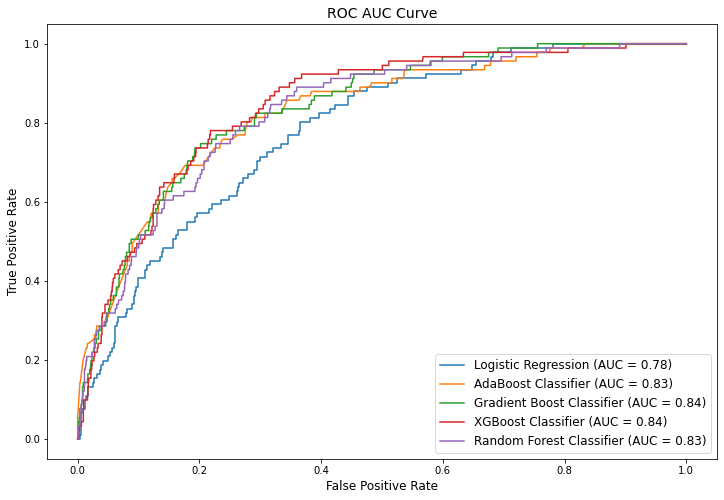

In [27]:
fig, ax = plt.subplots(figsize=(12, 8))

lr_disp = RocCurveDisplay.from_estimator(best_model_lr, X_val, y_val, name='Logistic Regression', ax=ax)
abc_disp = RocCurveDisplay.from_estimator(best_model_abc, X_val, y_val, name='AdaBoost Classifier', ax=ax)
gb_disp = RocCurveDisplay.from_estimator(best_model_gb, X_val, y_val, name='Gradient Boost Classifier', ax=ax)
xgb_disp = RocCurveDisplay.from_estimator(best_model_xgb, X_val, y_val, name='XGBoost Classifier', ax=ax)
rf_disp = RocCurveDisplay.from_estimator(best_model_rf, X_val, y_val, name='Random Forest Classifier', ax=ax)

ax.set_title('ROC AUC Curve', fontsize=14)
ax.legend(fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_xlabel('False Positive Rate', fontsize=12);

According to the above ROC, we can see that XGBoost (our chosen model) performs slightly better than all the other models due to the higher AUC.

**Sensitivity vs Precision Graph**

In [28]:
def plot_sensitivity_precision(model, label, ax):
    conf_matrix = []

    for threshold in np.linspace(0, 0.5, 25):
        y_preds = (model.predict_proba(X_val)[:, 1] > threshold).astype('float')
        tn, fp, fn, tp = confusion_matrix(y_val, y_preds).ravel()
        sensitivity = tp/(tp + fn)
        if (tp + fp) == 0:
            precision = 0
        else:
            precision = tp/(tp + fp)
        conf_matrix.append([threshold, sensitivity, precision])
                   
    matrix = pd.DataFrame(conf_matrix, columns=['threshold', 'sensitivity', 'precision'])    

    ax.plot(matrix['precision'], matrix['sensitivity'], label=label)
    ax.set_xlabel('Precision')
    ax.set_ylabel('Sensitivity')
    
    return matrix

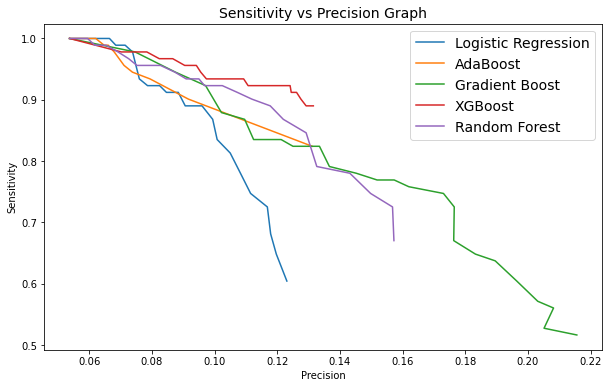

In [29]:
fig, ax = plt.subplots(figsize=(10, 6))

plot_sensitivity_precision(best_model_lr, 'Logistic Regression', ax)
plot_sensitivity_precision(best_model_abc, 'AdaBoost', ax)
plot_sensitivity_precision(best_model_gb, 'Gradient Boost', ax)
plot_sensitivity_precision(best_model_xgb, 'XGBoost',ax)
plot_sensitivity_precision(best_model_rf, 'Random Forest',ax)
ax.set_title('Sensitivity vs Precision Graph', fontsize=14)

ax.legend(fontsize=14);

According to the sensitivity vs precision graph above, XGBoost seems to be performing the best as it can achieve higher precision and sensitivity compared to other models.

# Final Model Selection

**XGBoost Model**

## Features Importance

Text(0.5, 1.0, 'Top 10 Feature Importance')

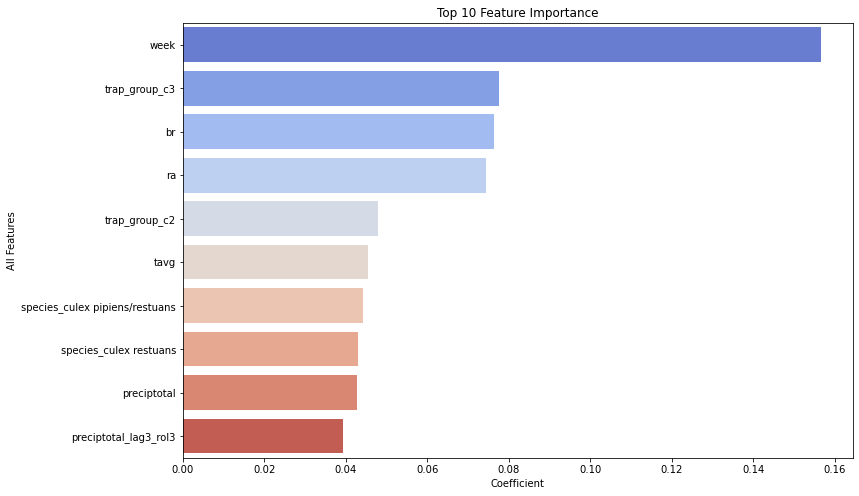

In [30]:
xgb_feat = best_model_xgb[:-1].get_feature_names_out()
xgb_feat_imp = best_model_xgb[2:3].steps[0][1].feature_importances_

df_xgb_feat = pd.DataFrame(data=xgb_feat_imp, index=xgb_feat, 
                          columns=['coefficient']).sort_values(by='coefficient', ascending=False).head(10)
df_xgb_feat.rename_axis('features', inplace=True)

plt.figure(figsize=(12,8))
sns.barplot(data=df_xgb_feat, y=df_xgb_feat.index, x='coefficient', palette='coolwarm')
plt.xlabel('Coefficient')
plt.ylabel('All Features')
plt.title('Top 10 Feature Importance')


**Important features:**
- week is the most important feature because it contains the pattern of seasonality on weekly basis
- The weather type(ra=rain, br=mist) 
- The grouping of traps
- Species

## Kaggle Submission for final prediction

In [31]:
X_test = test[final_feat]

In [32]:
X_train.shape, X_test.shape

((6780, 25), (116293, 25))

In [33]:
ss = StandardScaler()

X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [34]:
best_model_xgb.fit(X_train_sc, y_train)

/Users/kenneththesheep/opt/anaconda3/envs/dsi30/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:22:32] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('scale', StandardScaler()), ('sampling', SMOTE()),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, enable_categorical=False,
                               gamma=0.85, gpu_id=-1, importance_type=None,
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=40,
                               min_child_weight=25, missing=nan,
                               monotone_constraints='()', n_estimators=49,
                               n_jobs=-1, num_parallel_tree=1, predictor='auto',
                               random_state=42, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=63, subsample=1,
                               tree_method='exact', validate_parameters=1,
                               verbosity=1))])

In [35]:
#prediction for test data
#take first column which is 'id'
preds = best_model_xgb.predict_proba(X_test_sc)[:,1]
pred_df = pd.DataFrame({'Id': test['id'], 'WnvPresent': preds})

In [36]:
#Prediction probability for the test set:
pred_df[:5]

,Id,WnvPresent
0,1,0.016300
1,2,0.008640
2,3,0.012421
3,4,0.009845
4,5,0.009845


Kaggle submission

In [37]:
# #Export data to csv file to be submitted to Kaggle
pred_df.to_csv('../Dataset/submission_xgb.csv', index=False)

# from google.colab import files
# files.download("/content/gdrive/MyDrive/DSI30/P4/Dataset/submission_xgb.csv")

[LibLinear][01:22:01] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/kenneththesheep/opt/anaconda3/envs/dsi30/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/kenneththesheep/opt/anaconda3/envs/dsi30/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/kenneththesheep/opt/anaconda3/envs/dsi30/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index wit

[LibLinear][01:22:01] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:22:11] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[LibLinear][01:22:01] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was cha

/Users/kenneththesheep/opt/anaconda3/envs/dsi30/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/kenneththesheep/opt/anaconda3/envs/dsi30/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[LibLinear][LibLinear][01:22:01] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/kenneththesheep/opt/anaconda3/envs/dsi30/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/kenneththesheep/opt/anaconda3/envs/dsi30/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


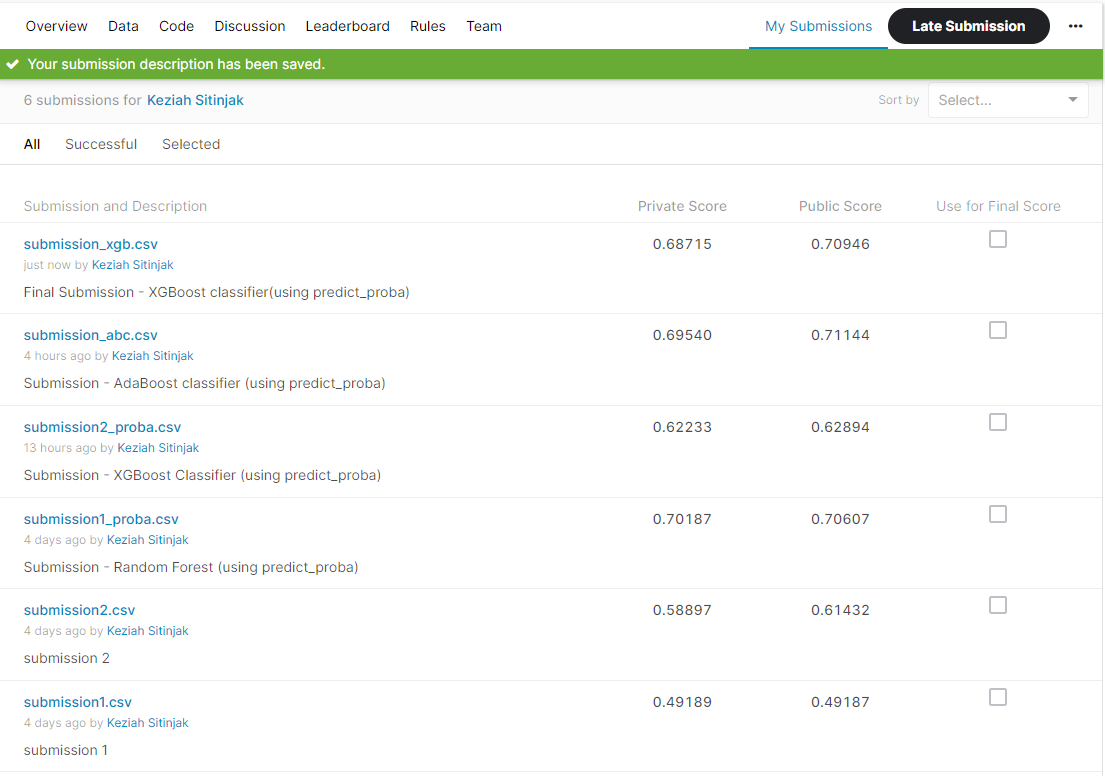